## Image autocorrelation -- going through different directories to extract data

In [15]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pickle
import scipy
from scipy.interpolate import interp1d
import skimage
from skimage import io, exposure, filters
import correlation_functions
from correlation_functions import autocorrelation_2D, autocorrelation_1D, find_where_corr_at_half

from numpy.fft import fftshift, fft2, ifft2, fft, ifft
from numpy import real
from numpy import conj

%matplotlib notebook

import openpyxl #this is for reading in Excel data


#### First, let's connect the video number to the shear rate

In [7]:
excel_file_direction = "Y:\\Dennis Terwilliger\\Data\\2021-10-23\\"
excel_filename = "2021-10-23_VideoData.xlsx"

wb = openpyxl.load_workbook(filename = excel_file_direction + excel_filename)
wb_sheet = wb['Sheet1']

video_number = [] #empty list where the video numbers will go
shear_rate = [] #empty list
start_row = 4
end_row = 36
column_for_videonum = 'A' #note that this is a string (that is, we have quotes around it)
column_for_shearrate = 'B'
for i in range(start_row, end_row+1):
    video_number.append(wb_sheet[column_for_videonum+"%i" % i].value)
    shear_rate.append(wb_sheet[column_for_shearrate+"%i" % i].value)

In [21]:
all_data = {}

In [53]:
def reportAvgAutoCorrelation(subdirectory_number, number_of_images_to_average=500, save_to_dictionary=True):
    '''
    This function will take the autocorrelation of many images in a movie. 
    It will find the movie based on the 'subdirectory_number' parameter given. 
    
    
    '''
    drive_letter = "Y"
    data_dir = drive_letter+":\\Dennis Terwilliger\\Data\\2021-10-23\\Videos\\Flow sweep for getting size vs shear rate at 25\\"
    sub_dir = "Flow_sweep_for_getting_size_vs_shear_rate_at_25_%i" % subdirectory_number
    data_file = "\\" + sub_dir + "_MMStack_Default.ome.tif"
    full_path = data_dir+sub_dir+data_file
    if not os.path.isfile(full_path):
        return 0

    #Enter the correct pixel size below: 
    pixel_size = 1.002


    #Initialize data structure to store analysis (type of structure known as dictionary)
    all_data['2021-10-23 - 25C - %i' % subdirectory_number] = {}
    all_data['2021-10-23 - 25C - %i' % subdirectory_number]['path'] = full_path
    all_data['2021-10-23 - 25C - %i' % subdirectory_number]['shear_rate'] = shear_rate[subdirectory_number-1]

    images = skimage.io.imread(data_dir+sub_dir+data_file)
    print("Number of frames in %s: %i" % (data_file, images.shape[0]))
    print("Dimensions of an image is %i by %i pixels." % (images.shape[1], images.shape[2]))

    ##Creating background
    mean_image = images.mean(axis=0)
    background = filters.gaussian(mean_image, sigma=120)
    
    number_of_frames = images.shape[0]
    frames_to_analyze = np.linspace(0, number_of_frames, num=number_of_images_to_average, endpoint=False, dtype=int)
    im = images[0,:,:]
    temp_corr2d = autocorrelation_2D(im)
    acorr0_from2d = temp_corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
    acorr1_from2d = temp_corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
    acorr0_all = np.zeros((number_of_images_to_average, len(acorr0_from2d)))
    acorr1_all = np.zeros((number_of_images_to_average, len(acorr1_from2d)))
    for i,frame in enumerate(frames_to_analyze):
        filtered_image = 1.0*images[frame,:,:] - background[:,:]
        temp_corr2d = autocorrelation_2D(filtered_image)
        acorr0_all[i] = temp_corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
        acorr1_all[i] = temp_corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
    avg_acorr0 = acorr0_all.mean(axis=0)
    avg_acorr1 = acorr1_all.mean(axis=0)


    all_data['2021-10-23 - 25C - %i' % subdirectory_number]['acorr0_all'] = acorr0_all
    all_data['2021-10-23 - 25C - %i' % subdirectory_number]['acorr1_all'] = acorr1_all
    all_data['2021-10-23 - 25C - %i' % subdirectory_number]['avg_acorr0'] = avg_acorr0
    all_data['2021-10-23 - 25C - %i' % subdirectory_number]['avg_acorr1'] = avg_acorr1
    
    where_autocorr_decay_0 = find_where_corr_at_half(avg_acorr0, val=0.5)
    where_autocorr_decay_1 = find_where_corr_at_half(avg_acorr1, val=0.5)
    
    all_data['2021-10-23 - 25C - %i' % subdirectory_number]['decay_length_0'] = where_autocorr_decay_0
    all_data['2021-10-23 - 25C - %i' % subdirectory_number]['decay_length_1'] = where_autocorr_decay_1

In [54]:
for subdirnum in video_number:
    reportAvgAutoCorrelation(subdirnum)

Number of frames in \Flow_sweep_for_getting_size_vs_shear_rate_at_25_1_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.
Number of frames in \Flow_sweep_for_getting_size_vs_shear_rate_at_25_2_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.
Number of frames in \Flow_sweep_for_getting_size_vs_shear_rate_at_25_3_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.
Number of frames in \Flow_sweep_for_getting_size_vs_shear_rate_at_25_4_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.
Number of frames in \Flow_sweep_for_getting_size_vs_shear_rate_at_25_5_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.
Number of frames in \Flow_sweep_for_getting_size_vs_shear_rate_at_25_6_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.
Number of frames in \Flow_sweep_for_getting_size_vs_shear_rate_at_25_8_MMStack_Default.ome.tif: 2000
Dimensions of an image 

In [55]:
shearrate_and_vortandflowsize = np.zeros((len(all_data),3),dtype=float)
for i,key in enumerate(all_data):
    shearrate_and_vortandflowsize[i,0] = all_data[key]['shear_rate']
    shearrate_and_vortandflowsize[i,1] = all_data[key]['decay_length_0']
    shearrate_and_vortandflowsize[i,2] = all_data[key]['decay_length_1']

<IPython.core.display.Javascript object>


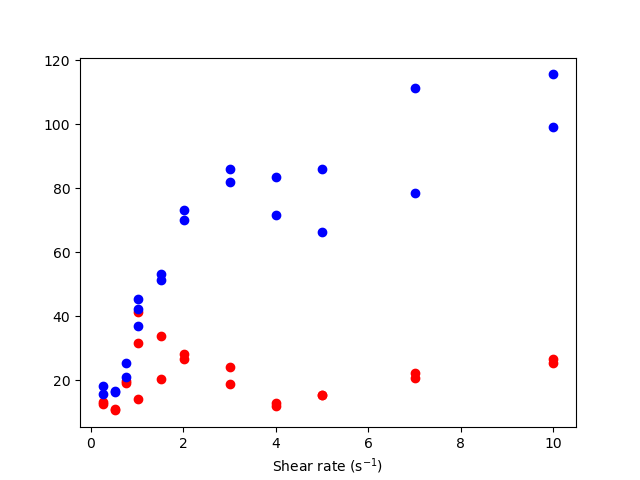

Text(0.5, 0, 'Shear rate (s$^{-1}$)')

In [56]:
fig = plt.figure()
plt.plot(shearrate_and_vortandflowsize[:,0], shearrate_and_vortandflowsize[:,1], 'ro', label='Vorticity direction')
plt.plot(shearrate_and_vortandflowsize[:,0], shearrate_and_vortandflowsize[:,2], 'bo', label='Flow direction')
plt.xlabel("Shear rate (s$^{-1}$)")

<IPython.core.display.Javascript object>


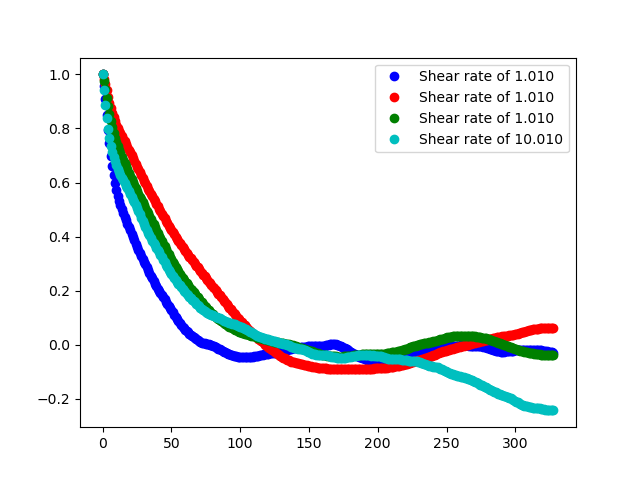

In [60]:
fig = plt.figure()

direction=0

x = np.arange(len(all_data['2021-10-23 - 25C - %i' % 1]['avg_acorr%i' % direction]))*1.002

num=8
plt.plot(x,all_data['2021-10-23 - 25C - %i' % num]['avg_acorr%i' % direction], 'bo', 
         label="Shear rate of %.3f" % all_data['2021-10-23 - 25C - %i' % num]['shear_rate'])

num=10
plt.plot(x,all_data['2021-10-23 - 25C - %i' % num]['avg_acorr%i' % direction], 'ro', 
         label="Shear rate of %.3f" % all_data['2021-10-23 - 25C - %i' % num]['shear_rate'])

num=11
plt.plot(x,all_data['2021-10-23 - 25C - %i' % num]['avg_acorr%i' % direction], 'go', 
         label="Shear rate of %.3f" % all_data['2021-10-23 - 25C - %i' % num]['shear_rate'])
num=33
plt.plot(x,all_data['2021-10-23 - 25C - %i' % num]['avg_acorr%i' % direction], 'co', 
         label="Shear rate of %.3f" % all_data['2021-10-23 - 25C - %i' % num]['shear_rate'])


plt.legend(loc=0)

In [36]:
all_data['2021-10-23 - 25C - 17'].keys()

dict_keys(['path', 'shear_rate', 'acorr0_all', 'acorr1_all', 'avg_acorr0', 'avg_acorr1', 'decay_length_0', 'decay_length_1'])

In [3]:
drive_letter = "Y"
data_dir = drive_letter+":\\Dennis Terwilliger\\Data\\2021-10-23\\Videos\\Flow sweep for getting size vs shear rate at 31\\"
sub_dir_number = 2 #CHANGE THIS TO CHANGE MOVIE ANALYZED!
sub_dir = "Flow_sweep_for_getting_size_vs_shear_rate_at_31_%i" % sub_dir_number
data_file = "\\" + sub_dir + "_MMStack_Default.ome.tif"
full_path = data_dir+sub_dir+data_file

#Enter the correct pixel size below: 
pixel_size = 0.501

'''
#Initialize data structure to store analysis (type of structure known as dictionary)
all_data['2021-08-10 - 04 - 01 - 1Hz'] = {}
all_data['2021-08-10 - 04 - 01 - 1Hz']['path'] = full_path
'''

images = skimage.io.imread(data_dir+sub_dir+data_file)
print("Number of frames in %s: %i" % (data_file, images.shape[0]))
print("Dimensions of an image is %i by %i pixels." % (images.shape[1], images.shape[2]))

##Creating background
mean_image = images.mean(axis=0)
background = filters.gaussian(mean_image, sigma=120)

Number of frames in \Flow_sweep_for_getting_size_vs_shear_rate_at_31_2_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.


<IPython.core.display.Javascript object>


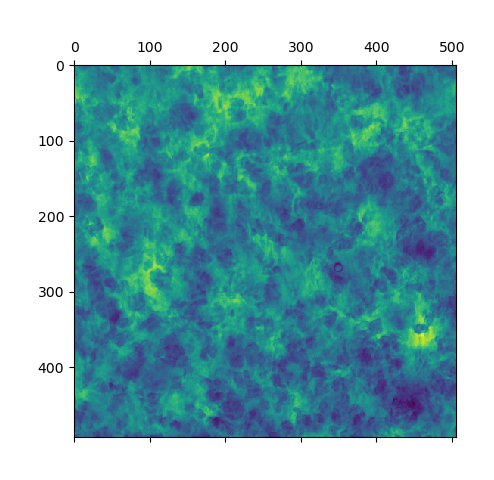

In [9]:
plt.matshow(images[0,:,150:])

In [10]:
########################################
# Take correlations...                 #
########################################

number_of_frames = images.shape[0]
number_to_analyze = 100
frames_to_analyze = np.linspace(0, number_of_frames, num=number_to_analyze, endpoint=False, dtype=int)
im = images[0,:,150:]
temp_corr2d = autocorrelation_2D(im)
acorr0_from2d = temp_corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
acorr1_from2d = temp_corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
acorr0_all = np.zeros((number_to_analyze, len(acorr0_from2d)))
acorr1_all = np.zeros((number_to_analyze, len(acorr1_from2d)))
for i,frame in enumerate(frames_to_analyze):
    filtered_image = 1.0*images[frame,:,150:] - background[:,150:]
    temp_corr2d = autocorrelation_2D(filtered_image)
    acorr0_all[i] = temp_corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
    acorr1_all[i] = temp_corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
avg_acorr0 = acorr0_all.mean(axis=0)
avg_acorr1 = acorr1_all.mean(axis=0)

"""
all_data['2021-08-10 - 04 - 01 - 1Hz']['acorr0_all'] = acorr0_all
all_data['2021-08-10 - 04 - 01 - 1Hz']['acorr1_all'] = acorr1_all
all_data['2021-08-10 - 04 - 01 - 1Hz']['avg_acorr0'] = avg_acorr0
all_data['2021-08-10 - 04 - 01 - 1Hz']['avg_acorr1'] = avg_acorr1
"""

"\nall_data['2021-08-10 - 04 - 01 - 1Hz']['acorr0_all'] = acorr0_all\nall_data['2021-08-10 - 04 - 01 - 1Hz']['acorr1_all'] = acorr1_all\nall_data['2021-08-10 - 04 - 01 - 1Hz']['avg_acorr0'] = avg_acorr0\nall_data['2021-08-10 - 04 - 01 - 1Hz']['avg_acorr1'] = avg_acorr1\n"

<IPython.core.display.Javascript object>


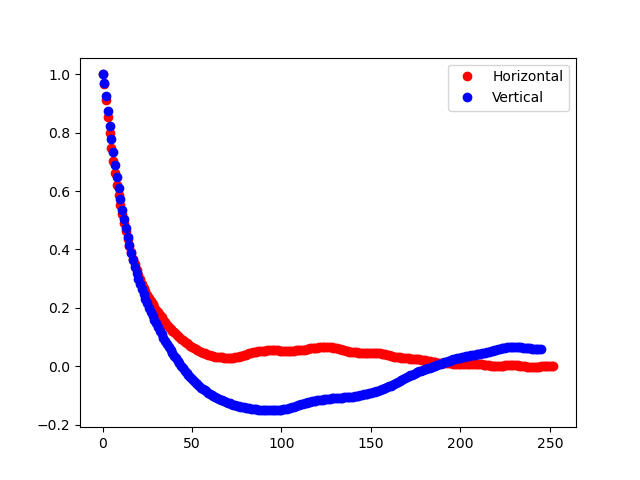

In [11]:
fig = plt.figure()
plt.plot(avg_acorr0,'ro',label='Horizontal')
plt.plot(avg_acorr1,'bo',label='Vertical')
plt.legend(loc=0)

<IPython.core.display.Javascript object>


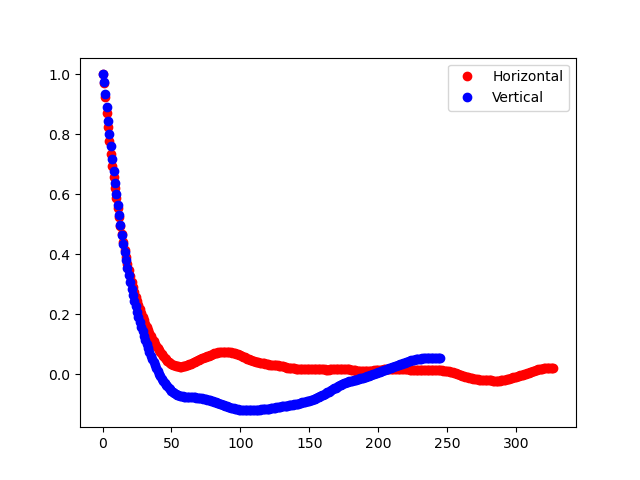

In [6]:
fig = plt.figure()
plt.plot(avg_acorr0,'ro',label='Horizontal')
plt.plot(avg_acorr1,'bo',label='Vertical')
plt.legend(loc=0)

In [17]:
drive_letter = "Y"
data_dir = drive_letter+":\\Dennis Terwilliger\\Data\\2021-10-23\\Videos\\Flow sweep for getting size vs shear rate at 31\\"
sub_dir_number = 18 #CHANGE THIS TO CHANGE MOVIE ANALYZED!
sub_dir = "Flow_sweep_for_getting_size_vs_shear_rate_at_31_%i" % sub_dir_number
data_file = "\\" + sub_dir + "_MMStack_Default.ome.tif"
full_path = data_dir+sub_dir+data_file

#Enter the correct pixel size below: 
pixel_size = 0.501

'''
#Initialize data structure to store analysis (type of structure known as dictionary)
all_data['2021-08-10 - 04 - 01 - 1Hz'] = {}
all_data['2021-08-10 - 04 - 01 - 1Hz']['path'] = full_path
'''

images = skimage.io.imread(data_dir+sub_dir+data_file)
print("Number of frames in %s: %i" % (data_file, images.shape[0]))
print("Dimensions of an image is %i by %i pixels." % (images.shape[1], images.shape[2]))

##Creating background
mean_image = images.mean(axis=0)
background = filters.gaussian(mean_image, sigma=120)

########################################
# Take correlations...                 #
########################################

number_of_frames = images.shape[0]
number_to_analyze = 100
frames_to_analyze = np.linspace(0, number_of_frames, num=number_to_analyze, endpoint=False, dtype=int)
im = images[0,:,150:]
temp_corr2d = autocorrelation_2D(im)
acorr0_from2d = temp_corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
acorr1_from2d = temp_corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
acorr0_all = np.zeros((number_to_analyze, len(acorr0_from2d)))
acorr1_all = np.zeros((number_to_analyze, len(acorr1_from2d)))
for i,frame in enumerate(frames_to_analyze):
    filtered_image = 1.0*images[frame,:,150:] - background[:,150:]
    temp_corr2d = autocorrelation_2D(filtered_image)
    acorr0_all[i] = temp_corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
    acorr1_all[i] = temp_corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
avg_acorr0 = acorr0_all.mean(axis=0)
avg_acorr1 = acorr1_all.mean(axis=0)

'''
all_data['2021-08-10 - 04 - 02 - 1Hz']['acorr0_all'] = acorr0_all
all_data['2021-08-10 - 04 - 02 - 1Hz']['acorr1_all'] = acorr1_all
all_data['2021-08-10 - 04 - 02 - 1Hz']['avg_acorr0'] = avg_acorr0
all_data['2021-08-10 - 04 - 02 - 1Hz']['avg_acorr1'] = avg_acorr1
'''

Number of frames in \Flow_sweep_for_getting_size_vs_shear_rate_at_31_18_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.


"\nall_data['2021-08-10 - 04 - 02 - 1Hz']['acorr0_all'] = acorr0_all\nall_data['2021-08-10 - 04 - 02 - 1Hz']['acorr1_all'] = acorr1_all\nall_data['2021-08-10 - 04 - 02 - 1Hz']['avg_acorr0'] = avg_acorr0\nall_data['2021-08-10 - 04 - 02 - 1Hz']['avg_acorr1'] = avg_acorr1\n"

<IPython.core.display.Javascript object>


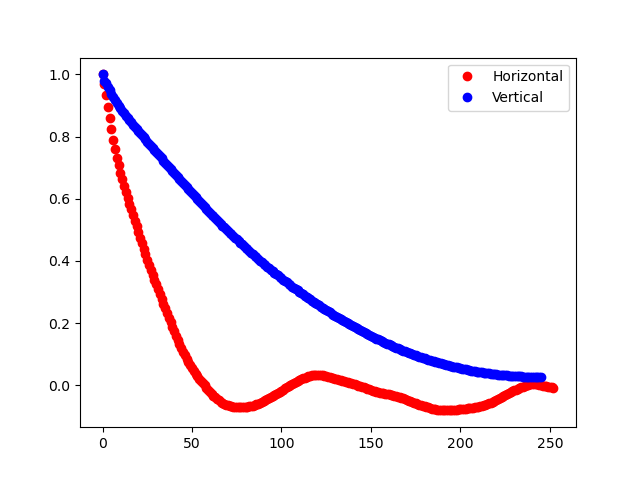

In [18]:
fig = plt.figure()
plt.plot(avg_acorr0,'ro',label='Horizontal')
plt.plot(avg_acorr1,'bo',label='Vertical')
plt.legend(loc=0)

In [63]:
drive_letter = "Y"
data_dir = drive_letter+":\\Dennis Terwilliger\\Data\\2021-08-10\\04_Flow_sweep_31Deg_10x\\"
sub_dir_number = 3 #CHANGE THIS TO CHANGE MOVIE ANALYZED!
sub_dir = "04_Flow_sweep_31Deg_10x_%i" % sub_dir_number
data_file = "\\" + sub_dir + "_MMStack_Default.ome.tif"
full_path = data_dir+sub_dir+data_file

#Enter the correct pixel size below: 
pixel_size = 1.02

#Initialize data structure to store analysis (type of structure known as dictionary)
all_data['2021-08-10 - 04 - 03 - 2Hz'] = {}
all_data['2021-08-10 - 04 - 03 - 2Hz']['path'] = full_path

images = skimage.io.imread(data_dir+sub_dir+data_file)
print("Number of frames in %s: %i" % (data_file, images.shape[0]))
print("Dimensions of an image is %i by %i pixels." % (images.shape[1], images.shape[2]))

##Creating background
mean_image = images.mean(axis=0)
background = filters.gaussian(mean_image, sigma=120)

########################################
# Take correlations...                 #
########################################

number_of_frames = images.shape[0]
number_to_analyze = 300
frames_to_analyze = np.linspace(0, number_of_frames, num=number_to_analyze, endpoint=False, dtype=int)
acorr0_all = np.zeros((number_to_analyze, len(acorr0_from2d)))
acorr1_all = np.zeros((number_to_analyze, len(acorr1_from2d)))
for i,frame in enumerate(frames_to_analyze):
    filtered_image = 1.0*images[frame] - background
    temp_corr2d = autocorrelation_2D(filtered_image)
    acorr0_all[i] = temp_corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
    acorr1_all[i] = temp_corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
avg_acorr0 = acorr0_all.mean(axis=0)
avg_acorr1 = acorr1_all.mean(axis=0)

all_data['2021-08-10 - 04 - 03 - 2Hz']['acorr0_all'] = acorr0_all
all_data['2021-08-10 - 04 - 03 - 2Hz']['acorr1_all'] = acorr1_all
all_data['2021-08-10 - 04 - 03 - 2Hz']['avg_acorr0'] = avg_acorr0
all_data['2021-08-10 - 04 - 03 - 2Hz']['avg_acorr1'] = avg_acorr1

Number of frames in \04_Flow_sweep_31Deg_10x_3_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.


In [64]:
drive_letter = "Y"
data_dir = drive_letter+":\\Dennis Terwilliger\\Data\\2021-08-10\\04_Flow_sweep_31Deg_10x\\"
sub_dir_number = 4 #CHANGE THIS TO CHANGE MOVIE ANALYZED!
sub_dir = "04_Flow_sweep_31Deg_10x_%i" % sub_dir_number
data_file = "\\" + sub_dir + "_MMStack_Default.ome.tif"
full_path = data_dir+sub_dir+data_file

#Enter the correct pixel size below: 
pixel_size = 1.02

#Initialize data structure to store analysis (type of structure known as dictionary)
all_data['2021-08-10 - 04 - 04 - 2Hz'] = {}
all_data['2021-08-10 - 04 - 04 - 2Hz']['path'] = full_path

images = skimage.io.imread(data_dir+sub_dir+data_file)
print("Number of frames in %s: %i" % (data_file, images.shape[0]))
print("Dimensions of an image is %i by %i pixels." % (images.shape[1], images.shape[2]))

##Creating background
mean_image = images.mean(axis=0)
background = filters.gaussian(mean_image, sigma=120)

########################################
# Take correlations...                 #
########################################

number_of_frames = images.shape[0]
number_to_analyze = 300
frames_to_analyze = np.linspace(0, number_of_frames, num=number_to_analyze, endpoint=False, dtype=int)
acorr0_all = np.zeros((number_to_analyze, len(acorr0_from2d)))
acorr1_all = np.zeros((number_to_analyze, len(acorr1_from2d)))
for i,frame in enumerate(frames_to_analyze):
    filtered_image = 1.0*images[frame] - background
    temp_corr2d = autocorrelation_2D(filtered_image)
    acorr0_all[i] = temp_corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
    acorr1_all[i] = temp_corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
avg_acorr0 = acorr0_all.mean(axis=0)
avg_acorr1 = acorr1_all.mean(axis=0)

all_data['2021-08-10 - 04 - 04 - 2Hz']['acorr0_all'] = acorr0_all
all_data['2021-08-10 - 04 - 04 - 2Hz']['acorr1_all'] = acorr1_all
all_data['2021-08-10 - 04 - 04 - 2Hz']['avg_acorr0'] = avg_acorr0
all_data['2021-08-10 - 04 - 04 - 2Hz']['avg_acorr1'] = avg_acorr1

Number of frames in \04_Flow_sweep_31Deg_10x_4_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.


In [65]:
drive_letter = "Y"
data_dir = drive_letter+":\\Dennis Terwilliger\\Data\\2021-08-10\\04_Flow_sweep_31Deg_10x\\"
sub_dir_number = 5 #CHANGE THIS TO CHANGE MOVIE ANALYZED!
sub_dir = "04_Flow_sweep_31Deg_10x_%i" % sub_dir_number
data_file = "\\" + sub_dir + "_MMStack_Default.ome.tif"
full_path = data_dir+sub_dir+data_file

#Enter the correct pixel size below: 
pixel_size = 1.02

#Initialize data structure to store analysis (type of structure known as dictionary)
all_data['2021-08-10 - 04 - 05 - 3Hz'] = {}
all_data['2021-08-10 - 04 - 05 - 3Hz']['path'] = full_path

images = skimage.io.imread(data_dir+sub_dir+data_file)
print("Number of frames in %s: %i" % (data_file, images.shape[0]))
print("Dimensions of an image is %i by %i pixels." % (images.shape[1], images.shape[2]))

##Creating background
mean_image = images.mean(axis=0)
background = filters.gaussian(mean_image, sigma=120)

########################################
# Take correlations...                 #
########################################

number_of_frames = images.shape[0]
number_to_analyze = 300
frames_to_analyze = np.linspace(0, number_of_frames, num=number_to_analyze, endpoint=False, dtype=int)
acorr0_all = np.zeros((number_to_analyze, len(acorr0_from2d)))
acorr1_all = np.zeros((number_to_analyze, len(acorr1_from2d)))
for i,frame in enumerate(frames_to_analyze):
    filtered_image = 1.0*images[frame] - background
    temp_corr2d = autocorrelation_2D(filtered_image)
    acorr0_all[i] = temp_corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
    acorr1_all[i] = temp_corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
avg_acorr0 = acorr0_all.mean(axis=0)
avg_acorr1 = acorr1_all.mean(axis=0)

all_data['2021-08-10 - 04 - 05 - 3Hz']['acorr0_all'] = acorr0_all
all_data['2021-08-10 - 04 - 05 - 3Hz']['acorr1_all'] = acorr1_all
all_data['2021-08-10 - 04 - 05 - 3Hz']['avg_acorr0'] = avg_acorr0
all_data['2021-08-10 - 04 - 05 - 3Hz']['avg_acorr1'] = avg_acorr1

Number of frames in \04_Flow_sweep_31Deg_10x_5_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.


In [77]:
drive_letter = "Y"
data_dir = drive_letter+":\\Dennis Terwilliger\\Data\\2021-08-10\\04_Flow_sweep_31Deg_10x\\"
sub_dir_number = 6 #CHANGE THIS TO CHANGE MOVIE ANALYZED!
sub_dir = "04_Flow_sweep_31Deg_10x_%i" % sub_dir_number
data_file = "\\" + sub_dir + "_MMStack_Default.ome.tif"
full_path = data_dir+sub_dir+data_file

#Enter the correct pixel size below: 
pixel_size = 1.02

#Initialize data structure to store analysis (type of structure known as dictionary)
all_data['2021-08-10 - 04 - 06 - 3Hz'] = {}
all_data['2021-08-10 - 04 - 06 - 3Hz']['path'] = full_path

images = skimage.io.imread(data_dir+sub_dir+data_file)
print("Number of frames in %s: %i" % (data_file, images.shape[0]))
print("Dimensions of an image is %i by %i pixels." % (images.shape[1], images.shape[2]))

##Creating background
mean_image = images.mean(axis=0)
background = filters.gaussian(mean_image, sigma=120)

########################################
# Take correlations...                 #
########################################

number_of_frames = images.shape[0]
number_to_analyze = 300
frames_to_analyze = np.linspace(0, number_of_frames, num=number_to_analyze, endpoint=False, dtype=int)
acorr0_all = np.zeros((number_to_analyze, len(acorr0_from2d)))
acorr1_all = np.zeros((number_to_analyze, len(acorr1_from2d)))
for i,frame in enumerate(frames_to_analyze):
    filtered_image = 1.0*images[frame] - background
    temp_corr2d = autocorrelation_2D(filtered_image)
    acorr0_all[i] = temp_corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
    acorr1_all[i] = temp_corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
avg_acorr0 = acorr0_all.mean(axis=0)
avg_acorr1 = acorr1_all.mean(axis=0)

all_data['2021-08-10 - 04 - 06 - 3Hz']['acorr0_all'] = acorr0_all
all_data['2021-08-10 - 04 - 06 - 3Hz']['acorr1_all'] = acorr1_all
all_data['2021-08-10 - 04 - 06 - 3Hz']['avg_acorr0'] = avg_acorr0
all_data['2021-08-10 - 04 - 06 - 3Hz']['avg_acorr1'] = avg_acorr1

Number of frames in \04_Flow_sweep_31Deg_10x_6_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.


In [67]:
drive_letter = "Y"
data_dir = drive_letter+":\\Dennis Terwilliger\\Data\\2021-08-10\\04_Flow_sweep_31Deg_10x\\"
sub_dir_number = 9 #CHANGE THIS TO CHANGE MOVIE ANALYZED!
sub_dir = "04_Flow_sweep_31Deg_10x_%i" % sub_dir_number
data_file = "\\" + sub_dir + "_MMStack_Default.ome.tif"
full_path = data_dir+sub_dir+data_file

#Enter the correct pixel size below: 
pixel_size = 1.02

#Initialize data structure to store analysis (type of structure known as dictionary)
all_data['2021-08-10 - 04 - 09 - 4Hz'] = {}
all_data['2021-08-10 - 04 - 09 - 4Hz']['path'] = full_path

images = skimage.io.imread(data_dir+sub_dir+data_file)
print("Number of frames in %s: %i" % (data_file, images.shape[0]))
print("Dimensions of an image is %i by %i pixels." % (images.shape[1], images.shape[2]))

##Creating background
mean_image = images.mean(axis=0)
background = filters.gaussian(mean_image, sigma=120)

########################################
# Take correlations...                 #
########################################

number_of_frames = images.shape[0]
number_to_analyze = 300
frames_to_analyze = np.linspace(0, number_of_frames, num=number_to_analyze, endpoint=False, dtype=int)
acorr0_all = np.zeros((number_to_analyze, len(acorr0_from2d)))
acorr1_all = np.zeros((number_to_analyze, len(acorr1_from2d)))
for i,frame in enumerate(frames_to_analyze):
    filtered_image = 1.0*images[frame] - background
    temp_corr2d = autocorrelation_2D(filtered_image)
    acorr0_all[i] = temp_corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
    acorr1_all[i] = temp_corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
avg_acorr0 = acorr0_all.mean(axis=0)
avg_acorr1 = acorr1_all.mean(axis=0)

all_data['2021-08-10 - 04 - 09 - 4Hz']['acorr0_all'] = acorr0_all
all_data['2021-08-10 - 04 - 09 - 4Hz']['acorr1_all'] = acorr1_all
all_data['2021-08-10 - 04 - 09 - 4Hz']['avg_acorr0'] = avg_acorr0
all_data['2021-08-10 - 04 - 09 - 4Hz']['avg_acorr1'] = avg_acorr1

Number of frames in \04_Flow_sweep_31Deg_10x_9_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.


In [68]:
drive_letter = "Y"
data_dir = drive_letter+":\\Dennis Terwilliger\\Data\\2021-08-10\\04_Flow_sweep_31Deg_10x\\"
sub_dir_number = 10 #CHANGE THIS TO CHANGE MOVIE ANALYZED!
sub_dir = "04_Flow_sweep_31Deg_10x_%i" % sub_dir_number
data_file = "\\" + sub_dir + "_MMStack_Default.ome.tif"
full_path = data_dir+sub_dir+data_file

#Enter the correct pixel size below: 
pixel_size = 1.02

#Initialize data structure to store analysis (type of structure known as dictionary)
all_data['2021-08-10 - 04 - 10 - 4Hz'] = {}
all_data['2021-08-10 - 04 - 10 - 4Hz']['path'] = full_path

images = skimage.io.imread(data_dir+sub_dir+data_file)
print("Number of frames in %s: %i" % (data_file, images.shape[0]))
print("Dimensions of an image is %i by %i pixels." % (images.shape[1], images.shape[2]))

##Creating background
mean_image = images.mean(axis=0)
background = filters.gaussian(mean_image, sigma=120)

########################################
# Take correlations...                 #
########################################

number_of_frames = images.shape[0]
number_to_analyze = 300
frames_to_analyze = np.linspace(0, number_of_frames, num=number_to_analyze, endpoint=False, dtype=int)
acorr0_all = np.zeros((number_to_analyze, len(acorr0_from2d)))
acorr1_all = np.zeros((number_to_analyze, len(acorr1_from2d)))
for i,frame in enumerate(frames_to_analyze):
    filtered_image = 1.0*images[frame] - background
    temp_corr2d = autocorrelation_2D(filtered_image)
    acorr0_all[i] = temp_corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
    acorr1_all[i] = temp_corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
avg_acorr0 = acorr0_all.mean(axis=0)
avg_acorr1 = acorr1_all.mean(axis=0)

all_data['2021-08-10 - 04 - 10 - 4Hz']['acorr0_all'] = acorr0_all
all_data['2021-08-10 - 04 - 10 - 4Hz']['acorr1_all'] = acorr1_all
all_data['2021-08-10 - 04 - 10 - 4Hz']['avg_acorr0'] = avg_acorr0
all_data['2021-08-10 - 04 - 10 - 4Hz']['avg_acorr1'] = avg_acorr1

Number of frames in \04_Flow_sweep_31Deg_10x_10_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.


In [69]:
drive_letter = "Y"
data_dir = drive_letter+":\\Dennis Terwilliger\\Data\\2021-08-10\\04_Flow_sweep_31Deg_10x\\"
sub_dir_number = 11 #CHANGE THIS TO CHANGE MOVIE ANALYZED!
sub_dir = "04_Flow_sweep_31Deg_10x_%i" % sub_dir_number
data_file = "\\" + sub_dir + "_MMStack_Default.ome.tif"
full_path = data_dir+sub_dir+data_file

#Enter the correct pixel size below: 
pixel_size = 1.02

#Initialize data structure to store analysis (type of structure known as dictionary)
all_data['2021-08-10 - 04 - 11 - 5Hz'] = {}
all_data['2021-08-10 - 04 - 11 - 5Hz']['path'] = full_path

images = skimage.io.imread(data_dir+sub_dir+data_file)
print("Number of frames in %s: %i" % (data_file, images.shape[0]))
print("Dimensions of an image is %i by %i pixels." % (images.shape[1], images.shape[2]))

##Creating background
mean_image = images.mean(axis=0)
background = filters.gaussian(mean_image, sigma=120)

########################################
# Take correlations...                 #
########################################

number_of_frames = images.shape[0]
number_to_analyze = 300
frames_to_analyze = np.linspace(0, number_of_frames, num=number_to_analyze, endpoint=False, dtype=int)
acorr0_all = np.zeros((number_to_analyze, len(acorr0_from2d)))
acorr1_all = np.zeros((number_to_analyze, len(acorr1_from2d)))
for i,frame in enumerate(frames_to_analyze):
    filtered_image = 1.0*images[frame] - background
    temp_corr2d = autocorrelation_2D(filtered_image)
    acorr0_all[i] = temp_corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
    acorr1_all[i] = temp_corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
avg_acorr0 = acorr0_all.mean(axis=0)
avg_acorr1 = acorr1_all.mean(axis=0)

all_data['2021-08-10 - 04 - 11 - 5Hz']['acorr0_all'] = acorr0_all
all_data['2021-08-10 - 04 - 11 - 5Hz']['acorr1_all'] = acorr1_all
all_data['2021-08-10 - 04 - 11 - 5Hz']['avg_acorr0'] = avg_acorr0
all_data['2021-08-10 - 04 - 11 - 5Hz']['avg_acorr1'] = avg_acorr1

Number of frames in \04_Flow_sweep_31Deg_10x_11_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.


In [70]:
drive_letter = "Y"
data_dir = drive_letter+":\\Dennis Terwilliger\\Data\\2021-08-10\\04_Flow_sweep_31Deg_10x\\"
sub_dir_number = 12 #CHANGE THIS TO CHANGE MOVIE ANALYZED!
sub_dir = "04_Flow_sweep_31Deg_10x_%i" % sub_dir_number
data_file = "\\" + sub_dir + "_MMStack_Default.ome.tif"
full_path = data_dir+sub_dir+data_file

#Enter the correct pixel size below: 
pixel_size = 1.02

#Initialize data structure to store analysis (type of structure known as dictionary)
all_data['2021-08-10 - 04 - 12 - 5Hz'] = {}
all_data['2021-08-10 - 04 - 12 - 5Hz']['path'] = full_path

images = skimage.io.imread(data_dir+sub_dir+data_file)
print("Number of frames in %s: %i" % (data_file, images.shape[0]))
print("Dimensions of an image is %i by %i pixels." % (images.shape[1], images.shape[2]))

##Creating background
mean_image = images.mean(axis=0)
background = filters.gaussian(mean_image, sigma=120)

########################################
# Take correlations...                 #
########################################

number_of_frames = images.shape[0]
number_to_analyze = 300
frames_to_analyze = np.linspace(0, number_of_frames, num=number_to_analyze, endpoint=False, dtype=int)
acorr0_all = np.zeros((number_to_analyze, len(acorr0_from2d)))
acorr1_all = np.zeros((number_to_analyze, len(acorr1_from2d)))
for i,frame in enumerate(frames_to_analyze):
    filtered_image = 1.0*images[frame] - background
    temp_corr2d = autocorrelation_2D(filtered_image)
    acorr0_all[i] = temp_corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
    acorr1_all[i] = temp_corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
avg_acorr0 = acorr0_all.mean(axis=0)
avg_acorr1 = acorr1_all.mean(axis=0)

all_data['2021-08-10 - 04 - 12 - 5Hz']['acorr0_all'] = acorr0_all
all_data['2021-08-10 - 04 - 12 - 5Hz']['acorr1_all'] = acorr1_all
all_data['2021-08-10 - 04 - 12 - 5Hz']['avg_acorr0'] = avg_acorr0
all_data['2021-08-10 - 04 - 12 - 5Hz']['avg_acorr1'] = avg_acorr1

Number of frames in \04_Flow_sweep_31Deg_10x_12_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.


In [71]:
print(all_data.keys())

dict_keys(['2021-08-10 - 04 - 01 - 1Hz', '2021-08-10 - 04 - 02 - 1Hz', '2021-08-10 - 04 - 03 - 2Hz', '2021-08-10 - 04 - 04 - 2Hz', '2021-08-10 - 04 - 05 - 3Hz', '2021-08-10 - 04 - 06 - 3Hz', '2021-08-10 - 04 - 09 - 4Hz', '2021-08-10 - 04 - 10 - 4Hz', '2021-08-10 - 04 - 11 - 5Hz', '2021-08-10 - 04 - 12 - 5Hz'])


<IPython.core.display.Javascript object>


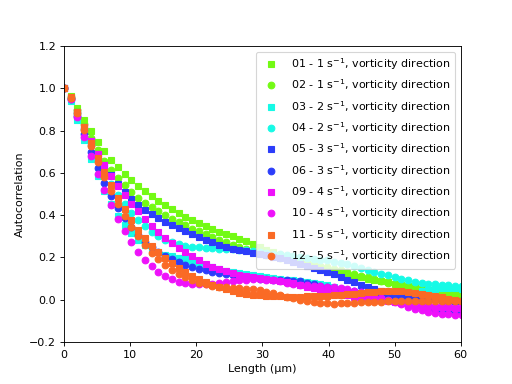

In [83]:
##################################
# Plots of the autocorr          #
#  VORTICITY DIRECTION           #
##################################
#color1 = '#27A4F2'
#color2 = '#186899'

colors_vort = ['#73FA14', '#16FAE6', '#2C3DFA', '#EE11FA', '#FA6A25']


plt.figure()


#Create plots of the autocorrleation
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 01 - 1Hz']['avg_acorr0']))*pixel_size, 
         all_data['2021-08-10 - 04 - 01 - 1Hz']['avg_acorr0'], 's', color=colors_vort[0], 
         label='01 - 1 s$^{-1}$, vorticity direction')
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 02 - 1Hz']['avg_acorr0']))*pixel_size, 
         all_data['2021-08-10 - 04 - 02 - 1Hz']['avg_acorr0'], 'o', color=colors_vort[0], 
         label='02 - 1 s$^{-1}$, vorticity direction')

plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 03 - 2Hz']['avg_acorr0']))*pixel_size, 
         all_data['2021-08-10 - 04 - 03 - 2Hz']['avg_acorr0'], 's', color=colors_vort[1], 
         label='03 - 2 s$^{-1}$, vorticity direction')
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 04 - 2Hz']['avg_acorr0']))*pixel_size, 
         all_data['2021-08-10 - 04 - 04 - 2Hz']['avg_acorr0'], 'o', color=colors_vort[1], 
         label='04 - 2 s$^{-1}$, vorticity direction')

plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 05 - 3Hz']['avg_acorr0']))*pixel_size, 
         all_data['2021-08-10 - 04 - 05 - 3Hz']['avg_acorr0'], 's', color=colors_vort[2], 
         label='05 - 3 s$^{-1}$, vorticity direction')
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 06 - 3Hz']['avg_acorr0']))*pixel_size, 
         all_data['2021-08-10 - 04 - 06 - 3Hz']['avg_acorr0'], 'o', color=colors_vort[2], 
         label='06 - 3 s$^{-1}$, vorticity direction')

plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 09 - 4Hz']['avg_acorr0']))*pixel_size, 
         all_data['2021-08-10 - 04 - 09 - 4Hz']['avg_acorr0'], 's', color=colors_vort[3], 
         label='09 - 4 s$^{-1}$, vorticity direction')
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 10 - 4Hz']['avg_acorr0']))*pixel_size, 
         all_data['2021-08-10 - 04 - 10 - 4Hz']['avg_acorr0'], 'o', color=colors_vort[3], 
         label='10 - 4 s$^{-1}$, vorticity direction')

plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 11 - 5Hz']['avg_acorr0']))*pixel_size, 
         all_data['2021-08-10 - 04 - 11 - 5Hz']['avg_acorr0'], 's', color=colors_vort[4], 
         label='11 - 5 s$^{-1}$, vorticity direction')
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 12 - 5Hz']['avg_acorr0']))*pixel_size, 
         all_data['2021-08-10 - 04 - 12 - 5Hz']['avg_acorr0'], 'o', color=colors_vort[4], 
         label='12 - 5 s$^{-1}$, vorticity direction')

#print("Where the correlation goes to 50% for axis 0: ", find_where_corr_at_half(avg_acorr0, val=0.5)*pixel_size)
#print("Where the correlation goes to 70% for axis 1: ", find_where_corr_at_half(avg_acorr1, val=0.7)*pixel_size)
#plt.title("Showing frame number %i" % frame_to_show)
plt.xlabel("Length (µm)")
plt.ylabel("Autocorrelation")
plt.xlim(0,60)
plt.ylim(-0.2,1.2)
plt.legend(loc=1)
#plt.savefig("AutoCorr_8-10_1s-1_and_5s-1.svg")

#Create figure for 2D autocorrelation
#plt.figure()
#plt.matshow(corr2d, fignum=0, cmap='gray')

<IPython.core.display.Javascript object>


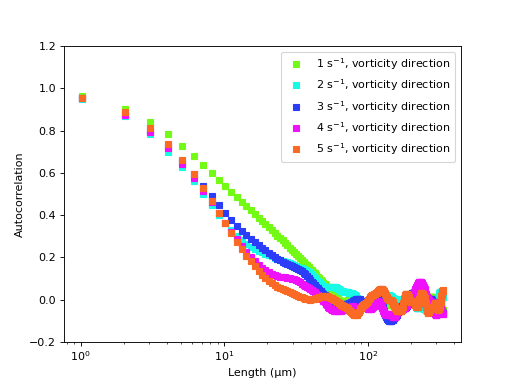

In [96]:
##################################
# Plots of the autocorr          #
#  VORTICITY DIRECTION           #
##################################
#color1 = '#27A4F2'
#color2 = '#186899'

colors_vort = ['#73FA14', '#16FAE6', '#2C3DFA', '#EE11FA', '#FA6A25']


plt.figure()


#Create plots of the autocorrleation
avg_1 = 0.5*(all_data['2021-08-10 - 04 - 02 - 1Hz']['avg_acorr0'] + all_data['2021-08-10 - 04 - 01 - 1Hz']['avg_acorr0'])
plt.semilogx(np.arange(len(all_data['2021-08-10 - 04 - 01 - 1Hz']['avg_acorr0']))*pixel_size, 
         avg_1, 's', color=colors_vort[0], 
         label='1 s$^{-1}$, vorticity direction')

avg_2 = 0.5*(all_data['2021-08-10 - 04 - 04 - 2Hz']['avg_acorr0'] + all_data['2021-08-10 - 04 - 03 - 2Hz']['avg_acorr0'])
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 03 - 2Hz']['avg_acorr0']))*pixel_size, 
         avg_2, 's', color=colors_vort[1], 
         label='2 s$^{-1}$, vorticity direction')

avg_3 = 0.5*(all_data['2021-08-10 - 04 - 06 - 3Hz']['avg_acorr0'] + all_data['2021-08-10 - 04 - 05 - 3Hz']['avg_acorr0'])
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 05 - 3Hz']['avg_acorr0']))*pixel_size, 
         avg_3, 's', color=colors_vort[2], 
         label='3 s$^{-1}$, vorticity direction')

avg_4 = 0.5*(all_data['2021-08-10 - 04 - 10 - 4Hz']['avg_acorr0'] + all_data['2021-08-10 - 04 - 09 - 4Hz']['avg_acorr0'])
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 09 - 4Hz']['avg_acorr0']))*pixel_size, 
         avg_4, 's', color=colors_vort[3], 
         label='4 s$^{-1}$, vorticity direction')

avg_5 = 0.5*(all_data['2021-08-10 - 04 - 12 - 5Hz']['avg_acorr0'] + all_data['2021-08-10 - 04 - 11 - 5Hz']['avg_acorr0'])
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 11 - 5Hz']['avg_acorr0']))*pixel_size, 
         avg_5, 's', color=colors_vort[4], 
         label='5 s$^{-1}$, vorticity direction')


#print("Where the correlation goes to 50% for axis 0: ", find_where_corr_at_half(avg_acorr0, val=0.5)*pixel_size)
#print("Where the correlation goes to 70% for axis 1: ", find_where_corr_at_half(avg_acorr1, val=0.7)*pixel_size)
#plt.title("Showing frame number %i" % frame_to_show)
plt.xlabel("Length (µm)")
plt.ylabel("Autocorrelation")
#plt.xlim(0,60)
plt.ylim(-0.2,1.2)
plt.legend(loc=1)
#plt.savefig("AutoCorr_8-10_1s-1_and_5s-1.svg")

#Create figure for 2D autocorrelation
#plt.figure()
#plt.matshow(corr2d, fignum=0, cmap='gray')

<IPython.core.display.Javascript object>


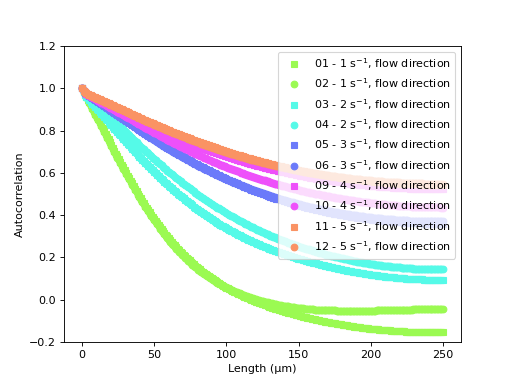

In [87]:
##################################
# Plots of the autocorr          #
#  FLOW DIRECTION                #
##################################
#color1 = '#27A4F2'
#color2 = '#186899'

colors_flow = ['#9BFA52', '#55FAE8', '#6B7AFA', '#EE50FA', '#FA9364']


plt.figure()


#Create plots of the autocorrleation
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 01 - 1Hz']['avg_acorr1']))*pixel_size, 
         all_data['2021-08-10 - 04 - 01 - 1Hz']['avg_acorr1'], 's', color=colors_flow[0], 
         label='01 - 1 s$^{-1}$, flow direction')
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 02 - 1Hz']['avg_acorr1']))*pixel_size, 
         all_data['2021-08-10 - 04 - 02 - 1Hz']['avg_acorr1'], 'o', color=colors_flow[0], 
         label='02 - 1 s$^{-1}$, flow direction')

plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 03 - 2Hz']['avg_acorr1']))*pixel_size, 
         all_data['2021-08-10 - 04 - 03 - 2Hz']['avg_acorr1'], 's', color=colors_flow[1], 
         label='03 - 2 s$^{-1}$, flow direction')
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 04 - 2Hz']['avg_acorr1']))*pixel_size, 
         all_data['2021-08-10 - 04 - 04 - 2Hz']['avg_acorr1'], 'o', color=colors_flow[1], 
         label='04 - 2 s$^{-1}$, flow direction')

plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 05 - 3Hz']['avg_acorr1']))*pixel_size, 
         all_data['2021-08-10 - 04 - 05 - 3Hz']['avg_acorr1'], 's', color=colors_flow[2], 
         label='05 - 3 s$^{-1}$, flow direction')
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 06 - 3Hz']['avg_acorr1']))*pixel_size, 
         all_data['2021-08-10 - 04 - 06 - 3Hz']['avg_acorr1'], 'o', color=colors_flow[2], 
         label='06 - 3 s$^{-1}$, flow direction')

plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 09 - 4Hz']['avg_acorr1']))*pixel_size, 
         all_data['2021-08-10 - 04 - 09 - 4Hz']['avg_acorr1'], 's', color=colors_flow[3], 
         label='09 - 4 s$^{-1}$, flow direction')
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 10 - 4Hz']['avg_acorr1']))*pixel_size, 
         all_data['2021-08-10 - 04 - 10 - 4Hz']['avg_acorr1'], 'o', color=colors_flow[3], 
         label='10 - 4 s$^{-1}$, flow direction')

plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 11 - 5Hz']['avg_acorr1']))*pixel_size, 
         all_data['2021-08-10 - 04 - 11 - 5Hz']['avg_acorr1'], 's', color=colors_flow[4], 
         label='11 - 5 s$^{-1}$, flow direction')
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 12 - 5Hz']['avg_acorr1']))*pixel_size, 
         all_data['2021-08-10 - 04 - 12 - 5Hz']['avg_acorr1'], 'o', color=colors_flow[4], 
         label='12 - 5 s$^{-1}$, flow direction')

#print("Where the correlation goes to 50% for axis 0: ", find_where_corr_at_half(avg_acorr0, val=0.5)*pixel_size)
#print("Where the correlation goes to 70% for axis 1: ", find_where_corr_at_half(avg_acorr1, val=0.7)*pixel_size)
#plt.title("Showing frame number %i" % frame_to_show)
plt.xlabel("Length (µm)")
plt.ylabel("Autocorrelation")
#plt.xlim(0,60)
plt.ylim(-0.2,1.2)
plt.legend(loc=1)
#plt.savefig("AutoCorr_8-10_1s-1_and_5s-1.svg")

#Create figure for 2D autocorrelation
#plt.figure()
#plt.matshow(corr2d, fignum=0, cmap='gray')

<IPython.core.display.Javascript object>


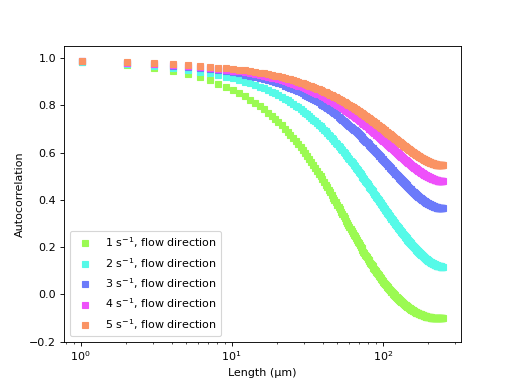

In [99]:
##################################
# Plots of the autocorr          #
#  FLOW DIRECTION                #
##################################
#color1 = '#27A4F2'
#color2 = '#186899'

colors_flow = ['#9BFA52', '#55FAE8', '#6B7AFA', '#EE50FA', '#FA9364']


plt.figure()


#Create plots of the autocorrleation
avg_1 = 0.5*(all_data['2021-08-10 - 04 - 02 - 1Hz']['avg_acorr1'] + all_data['2021-08-10 - 04 - 01 - 1Hz']['avg_acorr1'])
plt.semilogx(np.arange(len(all_data['2021-08-10 - 04 - 01 - 1Hz']['avg_acorr1']))*pixel_size, 
         avg_1, 's', color=colors_flow[0], 
         label='1 s$^{-1}$, flow direction')

avg_2 = 0.5*(all_data['2021-08-10 - 04 - 04 - 2Hz']['avg_acorr1'] + all_data['2021-08-10 - 04 - 03 - 2Hz']['avg_acorr1'])
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 03 - 2Hz']['avg_acorr1']))*pixel_size, 
         avg_2, 's', color=colors_flow[1], 
         label='2 s$^{-1}$, flow direction')

avg_3 = 0.5*(all_data['2021-08-10 - 04 - 06 - 3Hz']['avg_acorr1'] + all_data['2021-08-10 - 04 - 05 - 3Hz']['avg_acorr1'])
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 05 - 3Hz']['avg_acorr1']))*pixel_size, 
         avg_3, 's', color=colors_flow[2], 
         label='3 s$^{-1}$, flow direction')

avg_4 = 0.5*(all_data['2021-08-10 - 04 - 10 - 4Hz']['avg_acorr1'] + all_data['2021-08-10 - 04 - 09 - 4Hz']['avg_acorr1'])
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 09 - 4Hz']['avg_acorr1']))*pixel_size, 
         avg_4, 's', color=colors_flow[3], 
         label='4 s$^{-1}$, flow direction')

avg_5 = 0.5*(all_data['2021-08-10 - 04 - 12 - 5Hz']['avg_acorr1'] + all_data['2021-08-10 - 04 - 11 - 5Hz']['avg_acorr1'])
plt.plot(np.arange(len(all_data['2021-08-10 - 04 - 11 - 5Hz']['avg_acorr1']))*pixel_size, 
         avg_5, 's', color=colors_flow[4], 
         label='5 s$^{-1}$, flow direction')


#print("Where the correlation goes to 50% for axis 0: ", find_where_corr_at_half(avg_acorr0, val=0.5)*pixel_size)
#print("Where the correlation goes to 70% for axis 1: ", find_where_corr_at_half(avg_acorr1, val=0.7)*pixel_size)
#plt.title("Showing frame number %i" % frame_to_show)
plt.xlabel("Length (µm)")
plt.ylabel("Autocorrelation")
#plt.xlim(0,60)
plt.ylim(-0.2,1.05)
plt.legend(loc=0)
#plt.savefig("AutoCorr_8-10_1s-1_and_5s-1.svg")

#Create figure for 2D autocorrelation
#plt.figure()
#plt.matshow(corr2d, fignum=0, cmap='gray')

In [97]:
f = open(drive_letter+":\\Dennis Terwilliger\\Data\\2021-08-10\\Autocorr_lengths_Folder04-10x_300framespermovie.p",'wb')
pickle.dump(all_data, f)
f.close()

<IPython.core.display.Javascript object>


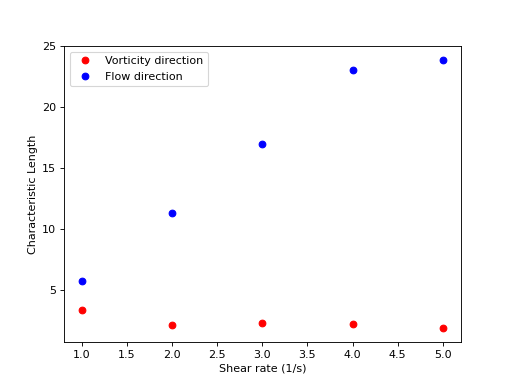

<IPython.core.display.Javascript object>


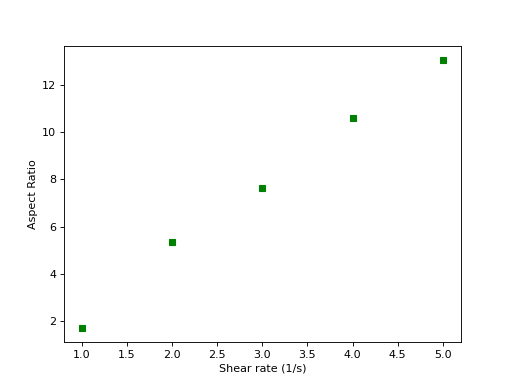

Text(0, 0.5, 'Aspect Ratio')

In [17]:
vort = np.array([3.33, 2.1, 2.23, 2.17, 1.83])
flow = np.array([5.68, 11.28, 16.98, 23.0,  23.90])
shear_rates = np.array([1,2,3,4,5])
plt.figure()
plt.plot(shear_rates, vort, 'ro', label="Vorticity direction")
plt.plot(shear_rates, flow, 'bo', label="Flow direction")
plt.xlabel("Shear rate (1/s)")
plt.ylabel("Characteristic Length")
plt.legend()

plt.figure()
plt.plot(shear_rates, flow/vort, 'gs')
plt.xlabel("Shear rate (1/s)")
plt.ylabel("Aspect Ratio")

In [56]:
def autocorr_decay_value(images, background, framenum, decay_fraction=0.7):
    filtered_image = 1.0 * images[framenum] - background
    corr2d = autocorrelation_2D(filtered_image)

    acorr0_from2d = corr2d[int(filtered_image.shape[0]/2),int(filtered_image.shape[1]/2):]
    acorr1_from2d = corr2d[int(filtered_image.shape[0]/2):,int(filtered_image.shape[1]/2)]
    where_autocorr_decay_0 = find_where_corr_at_half(acorr0_from2d, val=decay_fraction)
    where_autocorr_decay_1 = find_where_corr_at_half(acorr1_from2d, val=decay_fraction)
    return (where_autocorr_decay_0, where_autocorr_decay_1)

In [81]:
all_horizontal_lengthscales = np.zeros((im.shape[0]))
all_vertical_lengthscales = np.zeros_like(all_horizontal_lengthscales)
for i in range(0,im.shape[0]):
    all_horizontal_lengthscales[i], all_vertical_lengthscales[i] = autocorr_decay_value(images, background, i, decay_fraction=0.7)
    
all_data['2021-08-10 - 03 - 01 - 1Hz']['all_horizontal_lengthscales'] = all_horizontal_lengthscales
all_data['2021-08-10 - 03 - 01 - 1Hz']['all_vertical_lengthscales'] = all_vertical_lengthscales
all_data['2021-08-10 - 03 - 01 - 1Hz']['mean_horizontal_lengthscale'] = all_horizontal_lengthscales.mean()
all_data['2021-08-10 - 03 - 01 - 1Hz']['mean_vertical_lengthscale'] = all_vertical_lengthscales.mean()

<IPython.core.display.Javascript object>


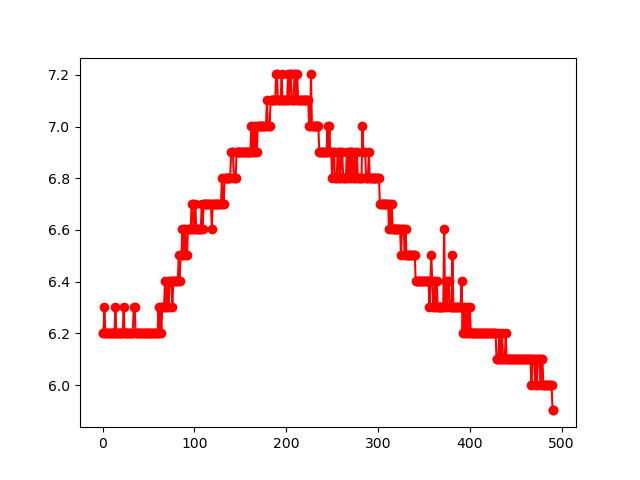

<IPython.core.display.Javascript object>


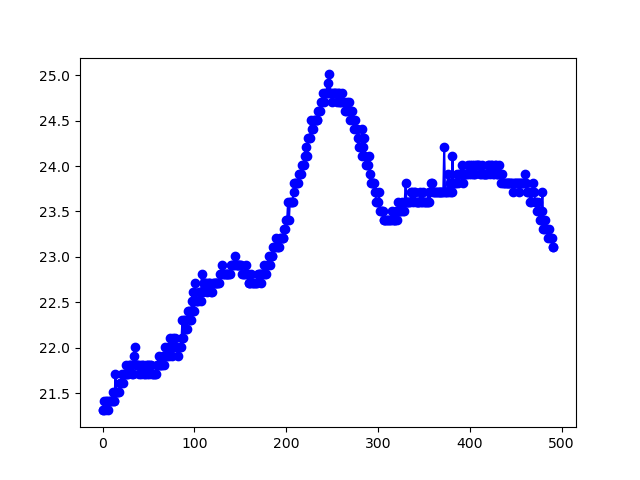

In [76]:
plt.figure()
plt.plot(all_horizontal_lengthscales,'-ro')
plt.figure()
plt.plot(all_vertical_lengthscales,'-bo')

<IPython.core.display.Javascript object>


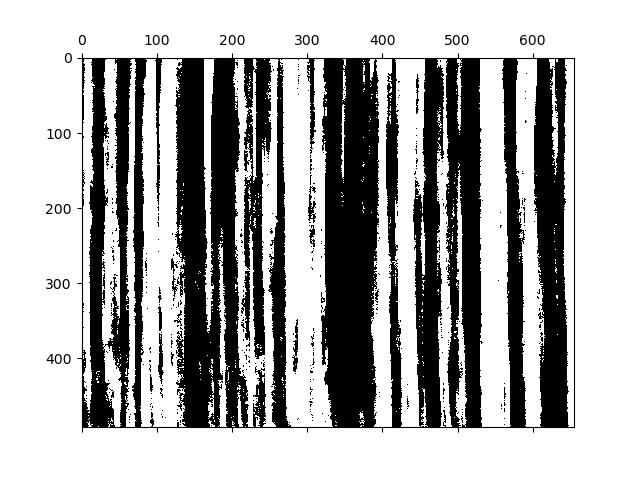

<IPython.core.display.Javascript object>


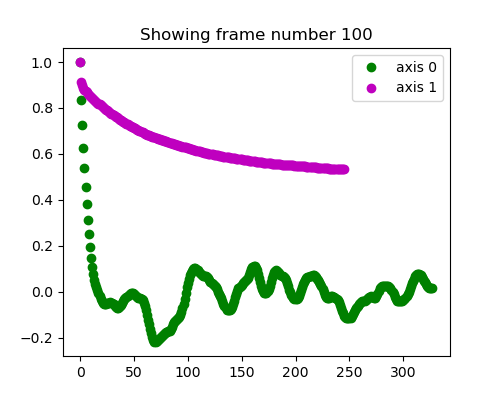

Where the correlation goes to 10% for axis 0:  107.93290637389448
Where the correlation goes to 10% for axis 1:  243.9991866612444


<ipython-input-19-0d19a49f7c3d>:35: RuntimeWarning: invalid value encountered in true_divide
  data = data / temp


In [61]:
#Convert image to binary (black and white)
block_size = 251
local_threshold = filters.threshold_local(filtered_image, block_size, offset=10)
binary_image = filtered_image > local_threshold

#Creates figure and shows region to analyze
plt.figure()
plt.matshow(binary_image, fignum=0, cmap='gray') #shows image

corr2d = autocorrelation_2D(binary_image)
plt.figure(figsize=(5,4))
acorr_0 = autocorrelation_1D(binary_image,0)
acorr_1 = autocorrelation_1D(binary_image,1)
#plt.plot(acorr_0,'bo',label='axis 0')
#plt.plot(acorr_1,'ro',label='axis 1')
acorr0_from2d = corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
acorr1_from2d = corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
plt.plot(acorr0_from2d, 'go', label='axis 0')
plt.plot(acorr1_from2d, 'mo', label='axis 1')
print("Where the correlation goes to 10% for axis 0: ", find_where_corr_at_half(acorr0_from2d, val=0.1))
print("Where the correlation goes to 10% for axis 1: ", find_where_corr_at_half(acorr1_from2d, val=0.1))
plt.title("Showing frame number %i" % frame_to_show)
plt.legend(loc=0)